In [ ]:
# Importing required Libraries
%reset
import numpy as np
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim # for gradient descent
import torchvision 
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

import matplotlib.pyplot as plt # for plotting
import os

torch.manual_seed(1) # set the random seed

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
##########################################################################################
# 2nd CNN - Learning to Classify Note Pitch (A - G)
##########################################################################################

!unzip '/content/drive/MyDrive/OMR/Note Pitch Dataset - Ver 3.zip' -d '/root/note_pitch_ver_3'

In [ ]:
# Define training and test data directories
data_dir = '/root/note_pitch_ver_3/Note Pitch Dataset'

In [ ]:
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'Undetermined']

# load and transform data using ImageFolder

# resize all images to 60 x 60
data_transform = transforms.Compose([transforms.Resize(size=(128, 128)), 
                                      transforms.ToTensor()])

full_data = datasets.ImageFolder(data_dir, transform=data_transform)

# print out data stats
print('Num training images: ', len(full_data))


Num training images:  1055


In [ ]:
data_train_square, data_val_square, data_test_square = torch.utils.data.random_split(full_data, [738, 211, 106])

In [ ]:
training_data_loader_notes_2 = torch.utils.data.DataLoader(data_train_square,
                                          batch_size=32,
                                          shuffle=True,
                                          num_workers=1)

validation_data_loader_notes_2 = torch.utils.data.DataLoader(data_val_square,
                                          batch_size=32,
                                          shuffle=True,
                                          num_workers=1)

test_data_loader_notes_2 = torch.utils.data.DataLoader(data_test_square,
                                          batch_size=32,
                                          shuffle=True,
                                          num_workers=1)

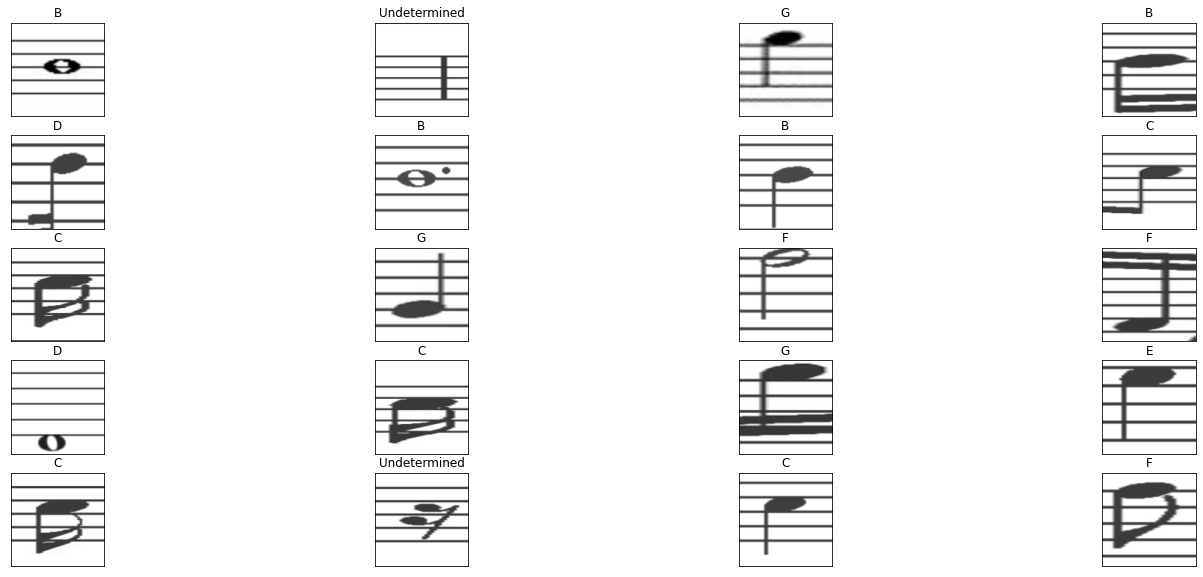

In [ ]:
# Visualize some training data

# obtain one batch of training images
dataiter = iter(training_data_loader_notes_2)
images_train_2, labels_train_2 = dataiter.next()
images_train_2 = images_train_2.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 10))
for idx in np.arange(20):
    ax = fig.add_subplot(5, 4, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images_train_2[idx], (1, 2, 0)))
    ax.set_title(classes[labels_train_2[idx]])

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=1)

        self.fc1 = nn.Linear(16, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = x.squeeze(1)
        return x

In [ ]:
import numpy as np
from tensorflow import keras


model = keras.models.Sequential()



# D = 5 (first parameter)
# Stride= (1,1) by default
model.add(keras.layers.Conv2D(6, kernel_size=5, activation='relu', input_shape=(128, 30, 3)))
model.add(keras.layers.MaxPool2D(2, 2))
model.add(keras.layers.Conv2D(16, kernel_size=3, activation='relu'))
model.add(keras.layers.MaxPool2D(2, 2))
model.add(keras.layers.MaxPool2D(2, 2))


model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 124, 26, 6)        456       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 62, 13, 6)        0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 11, 16)        880       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 30, 5, 16)        0         
 2D)                                                             
                                                                 
Total params: 1,336
Trainable params: 1,336
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class Net_2(nn.Module):
    def __init__(self):
        super(Net_2, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(8, 8)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        #x = x.squeeze(1)
        return x

In [ ]:
def get_accuracy_note_pitch_2(model, train=False):
    if train==True:
        a = training_data_loader_notes_2
    else:
        a = validation_data_loader_notes_2

    correct = 0
    total = 0


    # for imgs_notes, labels_notes in iter(a):#torch.utils.data.DataLoader(data, batch_size=64):
    for i, data in enumerate(a, 0):

       inputs, labels = data

       #############################################
       # To Enable GPU Usage
       if use_cuda and torch.cuda.is_available():
         inputs = inputs.cuda()
         labels = labels.cuda()
       #############################################

       output = model(inputs)
       # select index with maximum prediction score
       pred = output.max(1, keepdim=True)[1]
       correct += pred.eq(labels.view_as(pred)).sum().item()
       total += inputs.shape[0]
    return correct / total

In [ ]:
def train_net_3(model, n_epoch, learning_r, momentum): # Training our network

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_r, momentum=momentum)

    iters, losses, losses_ave, train_acc, val_acc = [], [], [], [], []
    epochs = []

    n = 0
    for epoch in range(n_epoch):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(training_data_loader_notes_2, 0): #training_data_loader_notes_2 or 
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            iters.append(n)
            losses.append(loss)
            losses_ave.append(float(loss)/32)             # compute *average* loss
            n += 1

        epochs.append(epoch)
        train_acc.append(get_accuracy_note_pitch_2(model, train=True)) # compute training accuracy 
        val_acc.append(get_accuracy_note_pitch_2(model, train=False))  # compute validation accuracy
        print("Epoch %d; Loss %f" % (epoch+1, loss))


    plt.plot(losses, label='Training loss')
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    # plt.plot(losses_ave, label='Training loss (ave)')
    # plt.show()
    print('Finished Training')

    # plotting
    '''
    plt.title("Training Curve")
    plt.plot(epochs, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()
    '''

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

Epoch 1; Loss 2.093771
Epoch 2; Loss 2.140085
Epoch 3; Loss 2.061066
Epoch 4; Loss 1.928690
Epoch 5; Loss 2.063499
Epoch 6; Loss 2.092997
Epoch 7; Loss 2.118719
Epoch 8; Loss 2.031660
Epoch 9; Loss 2.132839
Epoch 10; Loss 2.175881
Epoch 11; Loss 2.131090
Epoch 12; Loss 1.817088
Epoch 13; Loss 2.051068
Epoch 14; Loss 1.213899
Epoch 15; Loss 1.170400
Epoch 16; Loss 1.893448
Epoch 17; Loss 0.700422
Epoch 18; Loss 2.066479
Epoch 19; Loss 1.215652
Epoch 20; Loss 0.624473
Epoch 21; Loss 0.778630
Epoch 22; Loss 0.702727
Epoch 23; Loss 0.833996
Epoch 24; Loss 0.475849
Epoch 25; Loss 0.053041
Epoch 26; Loss 0.797576
Epoch 27; Loss 0.040482
Epoch 28; Loss 1.125334
Epoch 29; Loss 1.094136
Epoch 30; Loss 0.157101
Epoch 31; Loss 0.622384
Epoch 32; Loss 0.002446
Epoch 33; Loss 1.268398
Epoch 34; Loss 0.017418
Epoch 35; Loss 0.641183
Epoch 36; Loss 0.033604
Epoch 37; Loss 0.010836
Epoch 38; Loss 0.061006
Epoch 39; Loss 0.002201
Epoch 40; Loss 1.578753
Epoch 41; Loss 0.890751
Epoch 42; Loss 0.173532
E

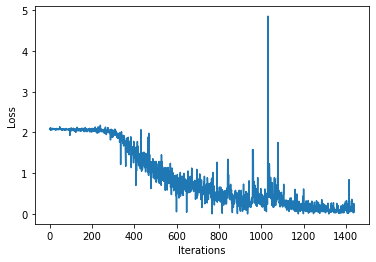

Finished Training


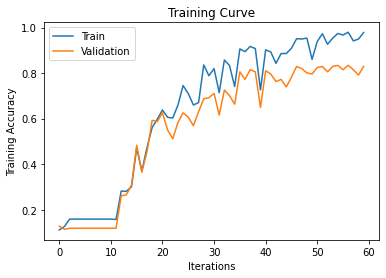

Final Training Accuracy: 0.978319783197832
Final Validation Accuracy: 0.8293838862559242


In [ ]:
use_cuda = True

model_CNN_test = Net_2()

train_net_3(model_CNN_test, 60, 0.009, 0.85)

Epoch 1; Loss 1.990729
Epoch 2; Loss 2.108495
Epoch 3; Loss 2.107724
Epoch 4; Loss 2.085176
Epoch 5; Loss 2.040183
Epoch 6; Loss 2.181513
Epoch 7; Loss 2.044539
Epoch 8; Loss 2.116091
Epoch 9; Loss 2.072520
Epoch 10; Loss 2.241251
Epoch 11; Loss 2.114270
Epoch 12; Loss 2.067736
Epoch 13; Loss 2.070143
Epoch 14; Loss 2.116646
Epoch 15; Loss 2.108021
Epoch 16; Loss 2.183183
Epoch 17; Loss 2.111056
Epoch 18; Loss 1.885234
Epoch 19; Loss 2.142145
Epoch 20; Loss 1.694327
Epoch 21; Loss 1.750941
Epoch 22; Loss 2.497569
Epoch 23; Loss 1.018168
Epoch 24; Loss 2.084709
Epoch 25; Loss 1.316679
Epoch 26; Loss 1.060671
Epoch 27; Loss 0.220843
Epoch 28; Loss 0.448423
Epoch 29; Loss 2.117624
Epoch 30; Loss 3.097966
Epoch 31; Loss 0.019510
Epoch 32; Loss 1.323603
Epoch 33; Loss 0.124625
Epoch 34; Loss 0.287681
Epoch 35; Loss 0.132182
Epoch 36; Loss 0.334193
Epoch 37; Loss 0.876375
Epoch 38; Loss 0.968550
Epoch 39; Loss 3.410689
Epoch 40; Loss 0.001665
Epoch 41; Loss 0.068397
Epoch 42; Loss 0.014014
E

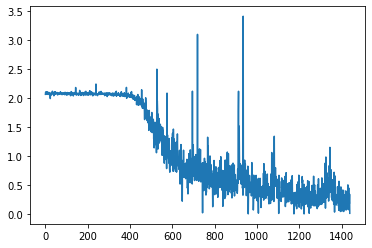

Finished Training


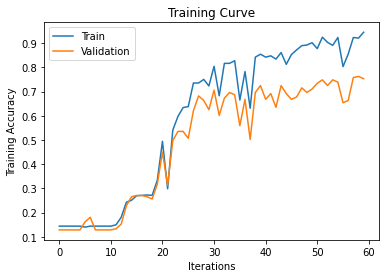

Final Training Accuracy: 0.94579945799458
Final Validation Accuracy: 0.7535545023696683


In [ ]:
use_cuda = True

model_CNN_test = Net_2()

train_net_3(model_CNN_test, 60, 0.009, 0.85)

Epoch 1; Loss 2.059870
Epoch 2; Loss 2.135803
Epoch 3; Loss 2.100378
Epoch 4; Loss 2.070969
Epoch 5; Loss 2.104904
Epoch 6; Loss 2.121037
Epoch 7; Loss 2.061584
Epoch 8; Loss 2.132876
Epoch 9; Loss 2.144712
Epoch 10; Loss 2.417606
Epoch 11; Loss 1.789716
Epoch 12; Loss 1.566766
Epoch 13; Loss 1.855906
Epoch 14; Loss 2.915134
Epoch 15; Loss 2.017960
Epoch 16; Loss 1.257140
Epoch 17; Loss 2.310162
Epoch 18; Loss 2.099316
Epoch 19; Loss 1.124285
Epoch 20; Loss 3.057651
Epoch 21; Loss 1.418202
Epoch 22; Loss 1.346861
Epoch 23; Loss 2.916920
Epoch 24; Loss 0.688685
Epoch 25; Loss 1.255388
Epoch 26; Loss 0.643239
Epoch 27; Loss 1.026061
Epoch 28; Loss 0.180965
Epoch 29; Loss 0.413238
Epoch 30; Loss 0.251095
Epoch 31; Loss 0.212593
Epoch 32; Loss 0.001368
Epoch 33; Loss 0.243728
Epoch 34; Loss 1.155998
Epoch 35; Loss 1.909057
Epoch 36; Loss 0.675242
Epoch 37; Loss 0.190106
Epoch 38; Loss 0.125827
Epoch 39; Loss 0.005914
Epoch 40; Loss 0.796949
Epoch 41; Loss 1.147862
Epoch 42; Loss 0.533166
E

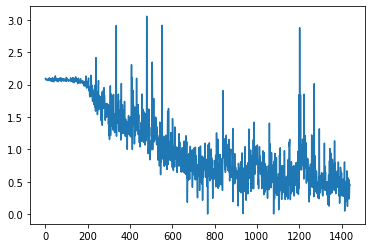

Finished Training


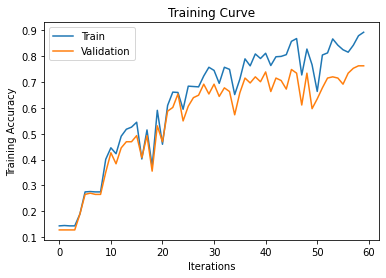

Final Training Accuracy: 0.8929539295392954
Final Validation Accuracy: 0.7630331753554502


In [ ]:
use_cuda = True

model_CNN_test = Net_2()

train_net_3(model_CNN_test, 60, 0.008, 0.9)

In [ ]:
dataiter_test = iter(test_data_loader_notes_2)
images_test, labels_test = dataiter_test.next()

out = torch.sigmoid(model_CNN_test( images_test[0].unsqueeze(0) )) #input_test.unsqueeze(0)
pred = out.max(1, keepdim=True)[1]

predicted_class = classes[pred]

print(predicted_class)

A


Model predicted:  A
Actual classification:  A


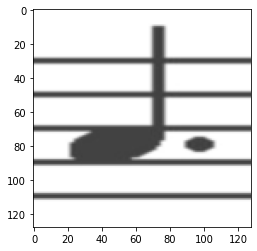

In [ ]:
images_test_first_image = images_test[0].numpy()
plt.imshow(np.transpose(images_test_first_image, (1, 2, 0)))

print("Model predicted: ", predicted_class)
print("Actual classification: ", classes[labels_test[0]])


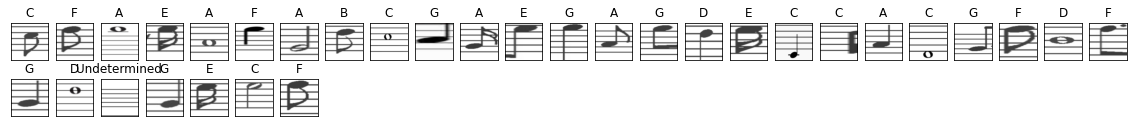

In [ ]:
predictions = []
images_test, labels_test = dataiter_test.next()

for i in range(0, 32):

  out = torch.sigmoid(model_CNN_test( images_test[i].unsqueeze(0) )) #input_test.unsqueeze(0)
  pred = out.max(1, keepdim=True)[1]
  predicted_class = classes[pred]
  predictions.append(predicted_class)


images_test = images_test.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 5))
for idx in np.arange(32):
    ax = fig.add_subplot(5, 25, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images_test[idx], (1, 2, 0)))
    ax.set_title(predictions[idx])

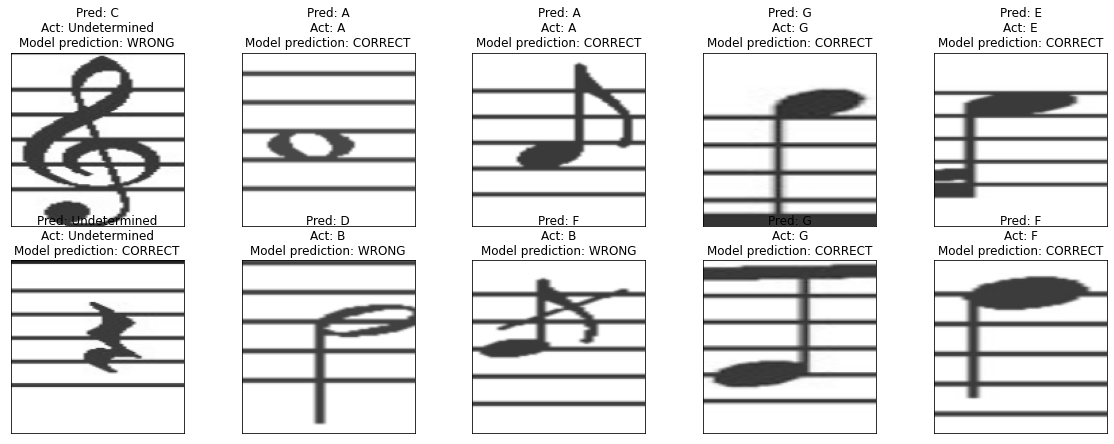

In [ ]:
predictions = []
images_test, labels_test = dataiter_test.next()

for i in range(0, 32):

  out = torch.sigmoid(model_CNN_test( images_test[i].unsqueeze(0) )) #input_test.unsqueeze(0)
  pred = out.max(1, keepdim=True)[1]
  predicted_class = classes[pred]
  predictions.append(predicted_class)


images_test = images_test.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 7))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images_test[idx], (1, 2, 0)))



    pred = predictions[idx]
    actual_class = classes[labels_test[idx]]
    if pred != actual_class:
      correct_pred = "WRONG"
    else:
      correct_pred = "CORRECT"
    plot_title = "Pred: " + pred + "\n" + "Act: " + actual_class + "\nModel prediction: " + correct_pred

    ax.set_title(plot_title)



    #ax.set_title(predictions[idx])

In [ ]:
test_data_loader_notes_2
for i, data in enumerate(training_data_loader_notes_2, 0): #training_data_loader_notes_2 or 
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)

# Visualize some training data

# obtain one batch of training images
dataiter = iter(training_data_loader_notes)
images_train, labels_train = dataiter.next()
images_train = images_train.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 5))
for idx in np.arange(100):
    ax = fig.add_subplot(5, 25, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images_train[idx], (1, 2, 0)))
    ax.set_title(classes[labels_train[idx]])


input_test = torch.tensor(  )

out = torch.sigmoid(model( input_test.unsqueeze(0) ))
pred = out.max(1, keepdim=True)[1]

predicted_class = classes[pred]

print(predicted_class)